# Building an Autoencoder with Haiku and JAX

*Prof Christopher Tunnell, 20-May-2024, HSF-India, U. Delhi*

This tutorial will guide you through the process of building an autoencoder using Haiku and JAX. The tutorial is designed for physics PhD students who may not have a deep understanding of programming or machine learning.

## Step 1: Install Necessary Libraries

These are pre-installed for this demo - but you can see them in the `requirements.txt` file that is next to this file.

### Concept:
We will use JAX for high-performance numerical computing, Haiku for building neural networks, Optax for optimization, and other supporting libraries.  (These should be installed.)


## Step 2: Define the Autoencoder Model

An autoencoder is a type of neural network used to learn efficient representations of data, typically for the purpose of dimensionality reduction or feature learning. It consists of two main parts: the encoder and the decoder.

### Concept:
The encoder compresses the input data into a smaller, latent space representation, and the decoder reconstructs the original data from this compressed representation.

Learn more about [Autoencoders on Wikipedia](https://en.wikipedia.org/wiki/Autoencoder).

In [50]:
import haiku as hk
import jax
import jax.numpy as jnp
from jax import random

class Autoencoder(hk.Module):
    def __init__(self, encoder_layers, decoder_layers):
        super().__init__()
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers

    def __call__(self, x):
        # Encoder
        for units in self.encoder_layers:
            x = hk.Linear(units)(x)
            x = jax.nn.tanh(x)

        # Latent space
        latent = x

        # Decoder
        for units in self.decoder_layers[:-1]:
            x = hk.Linear(units)(x)
            x = jax.nn.tanh(x)

        # Output layer
        x = hk.Linear(self.decoder_layers[-1])(x)
        return x, latent

### Explanation:
1. **Encoder**:
    - The encoder compresses the input data into a latent space.
    - Each layer in the encoder is a dense layer followed by a tanh activation function.

2. **Latent Space**:
    - The compressed representation of the input data.

3. **Decoder**:
    - The decoder reconstructs the data from the latent space.
    - Each layer in the decoder is a dense layer followed by a tanh activation function.
    - The final layer outputs the reconstructed data.

## Step 3: Create a Train State

To train the neural network, we need to manage the model parameters and the optimizer state. This step involves creating a training state that includes these components.

### Concept:
We initialize the model parameters and set up the optimizer, which will update the model parameters during training to minimize the loss function.

Learn more about [Optimization in Machine Learning on Wikipedia](https://en.wikipedia.org/wiki/Optimization_(mathematics)).

In [51]:
import optax

def create_train_state(rng, model, learning_rate, input_shape):
    params = model.init(rng, jnp.ones(input_shape))
    tx = optax.adam(learning_rate)
    opt_state = tx.init(params)
    return params, opt_state, tx

### Explanation:
1. **Model Initialization**:
    - We initialize the model parameters using a random key (`rng`) and a dummy input.

2. **Optimizer**:
    - We use the Adam optimizer with a specified learning rate.
    - The optimizer state is initialized using the model parameters.

## Step 4: Define the Loss Function and Update Step

To train the autoencoder, we need a loss function that measures the difference between the original and reconstructed data. Additionally, we define an update step to adjust the model parameters based on this loss.

### Concept:
The loss function helps us quantify how well the autoencoder is performing, and the update step involves using gradient descent to minimize this loss.

Learn more about [Loss Functions on Wikipedia](https://en.wikipedia.org/wiki/Loss_function).

In [52]:
def compute_loss(params, rng, batch):
    preds, _ = model.apply(params, rng, batch)
    loss = jnp.mean((preds - batch) ** 2)
    return loss

@jax.jit
def update(params, opt_state, rng, batch):
    rng, new_rng = random.split(rng)
    loss, grads = jax.value_and_grad(compute_loss)(params, rng, batch)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss, new_rng

### Explanation:
1. **Loss Function**:
    - The `compute_loss` function calculates the mean squared error between the predicted and actual data.

2. **Update Step**:
    - The `update` function calculates the gradients of the loss with respect to the model parameters.
    - The optimizer updates the model parameters using the gradients.

## Step 5: Prepare the Data

We will use the Digits dataset from scikit-learn for training the autoencoder. The data is scaled to have zero mean and unit variance.

### Concept:
Data preprocessing is crucial for machine learning as it ensures that the data is in a suitable format and scale for the model to learn effectively.

Learn more about the [Digits Dataset on Wikipedia](https://en.wikipedia.org/wiki/Optical_character_recognition).

In [77]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

# Load and scale the data
digits = load_digits()
data = digits.data
#scaler = StandardScaler()
#data = scaler.fit_transform(data)

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

### Explanation:
1. **Loading the Data**:
    - We load the Digits dataset using scikit-learn.

2. **Scaling the Data**:
    - We scale the data to have zero mean and unit variance using StandardScaler.

3. **Splitting the Data**:
    - We split the data into training and testing sets.
    
## Visualize the data

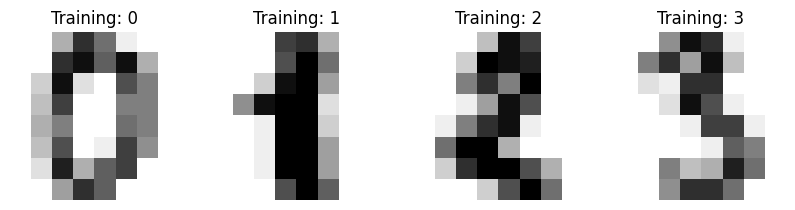

In [172]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image,
              cmap=plt.cm.gray_r,
              interpolation="nearest",
              vmin=0, vmax=16)
    ax.set_title("Training: %i" % label)

## Step 6: Train the Autoencoder

We will train the autoencoder using the training data and evaluate it using the test data.

### Concept:
Training involves feeding the data through the autoencoder, computing the loss, and updating the model parameters to minimize this loss. We also evaluate the model on test data to monitor its performance.

Learn more about [Backpropagation on Wikipedia](https://en.wikipedia.org/wiki/Backpropagation).

In [86]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Initialize model and training state
rng = random.PRNGKey(0)
model = hk.transform(lambda x: Autoencoder([128, 64, 64, 64], [64, 64, 64, 128, data.shape[1]])(x))
params, opt_state, tx = create_train_state(rng, model, learning_rate=0.001, input_shape=(data.shape[1],))

# Training loop
num_epochs = 1000
batch_size = 32
train_losses = []
test_losses = []

for epoch in tqdm(range(num_epochs)):
    for i in range(0, len(train_data), batch_size):
        batch = train_data[i:i + batch_size]
        params, opt_state, train_loss, rng = update(params, opt_state, rng, batch)

    rng, new_rng = random.split(rng)
    test_loss = compute_loss(params, new_rng, test_data)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Explanation:
1. **Initialize Model and Training State**:
    - We create a random key `rng` and initialize the autoencoder model with specified encoder and decoder layers.
    - We create the initial training state using the `create_train_state` function.

2. **Training Loop**:
    - We specify the number of epochs (`num_epochs`) and batch size (`batch_size`).
    - We initialize lists to store the training and validation losses.

3. **Epoch Loop**:
    - We use `tqdm` to create a progress bar for the training loop.
    - For each epoch, we iterate over the training data in batches, updating the model parameters using the `update` function.
    - After processing all batches in an epoch, we compute the validation loss using `compute_loss` and store the losses.

## Step 7: Plot the Training and Validation Losses

After training the autoencoder, we can visualize the training and validation losses over epochs to understand how well the model is learning.

### Concept:
Plotting the losses helps us monitor the training process and detect issues like overfitting, where the model performs well on training data but poorly on test data.

Learn more about [Loss Functions and Training on Wikipedia](https://en.wikipedia.org/wiki/Loss_function).

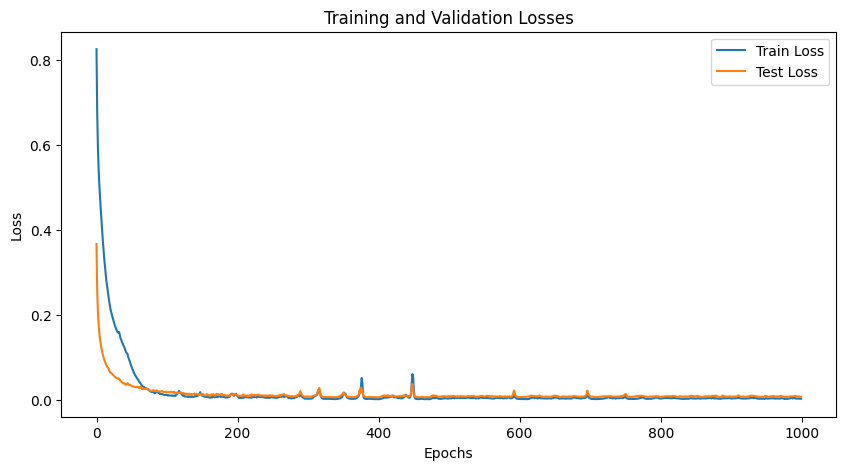

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
#plt.yscale('log')
plt.show()

### Explanation:
1. **Plotting**:
    - We use Matplotlib to create a plot of the training and validation losses over epochs.
    - We label the x-axis as 'Epochs' and the y-axis as 'Loss'.
    - We add a legend to distinguish between training and validation losses.
    - We set the title of the plot to 'Training and Validation Losses'.
    - Finally, we displayed the plot.
    
## Step 8: Check the prediction

We can compare the image input and output.

### Concept:
If the network has learned what a number looks like, then the input and outputs should look similar.

Learn more about [XX on Wikipedia](https://en.wikipedia.org/wiki/XX).

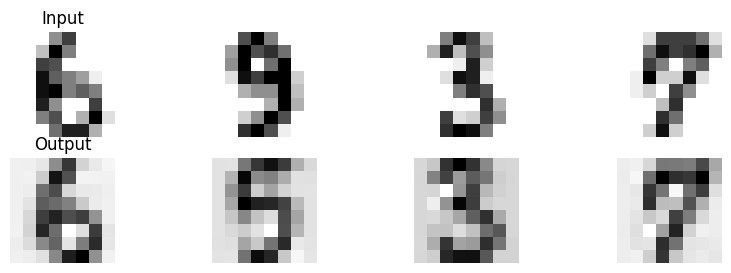

In [183]:
_, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 3))
predicted_data, _ = model.apply(params, rng, test_data)
for i in range(4):
    axes[0][i].set_axis_off()
    axes[0][i].imshow(test_data[i].reshape(8, 8),
                      cmap=plt.cm.gray_r, interpolation="nearest")
    
    axes[1][i].set_axis_off()
    axes[1][i].imshow(predicted_data[i].reshape(8, 8),
                      cmap=plt.cm.gray_r, interpolation="nearest")
axes[0][0].set_title('Input')
_= axes[1][0].set_title('Output')

### Explanation:
1. They look alike.
    
## Step 9: Anomaly detection

We can make an anomaly detector to learn if bad data as the network prediction will be illdefined and different from the input.

### Concept:
This is a way to find bad data.

Learn more about [XX on Wikipedia](https://en.wikipedia.org/wiki/XX).

In [189]:
bad_data = test_data.copy()
bad_data[0] = jax.random.randint(rng, shape=(64,), minval=0, maxval=16)
bad_data[1] = bad_data[1].reshape(8, 8).T.reshape(64)
bad_data[2] = bad_data[2].reshape(8, 8).T.reshape(64)
bad_data[3] = 16 * jnp.ones(64)

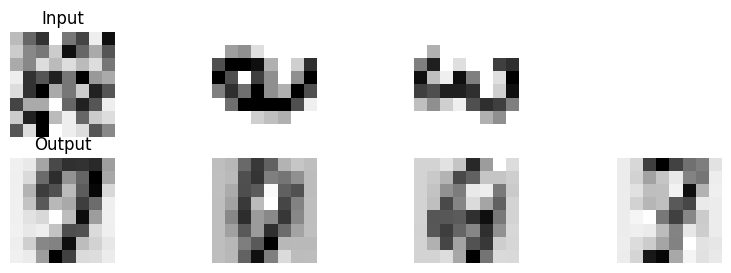

In [190]:
_, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 3))
predicted_bad_data, _ = model.apply(params, rng, bad_data)
for i in range(4):
    axes[0][i].set_axis_off()
    axes[0][i].imshow(bad_data[i].reshape(8, 8),
                      cmap=plt.cm.gray_r, interpolation="nearest")
    
    axes[1][i].set_axis_off()
    axes[1][i].imshow(predicted_bad_data[i].reshape(8, 8),
                      cmap=plt.cm.gray_r, interpolation="nearest")
axes[0][0].set_title('Input')
_= axes[1][0].set_title('Output')

In [191]:
print(f'The loss is: {compute_loss(params, new_rng, bad_data)}')

The loss is: 7.135401725769043


This loss is higher than the loss we see above, indicating anomalous data.

## End

In [120]:
model.apply(params, rng, predicted_data[1].reshape(8, 8).T.reshape(1, -1))

(Array([[-8.94270837e-04,  6.63028836e-01,  5.27374029e+00,
          1.24272223e+01,  1.24554739e+01,  4.90373135e+00,
         -1.24579084e+00, -7.49085426e-01, -4.84601930e-02,
          1.64811277e+00,  1.06121016e+01,  1.58493290e+01,
          1.07854223e+01,  4.58792305e+00,  6.85023546e-01,
         -1.39780119e-01,  1.68298408e-01,  6.93191004e+00,
          1.87818451e+01,  1.66717796e+01,  4.85504723e+00,
         -1.06605542e+00,  3.43129635e-01,  9.25020128e-03,
          1.18351594e-01,  6.82111216e+00,  1.45847874e+01,
          1.30521860e+01,  1.42896235e+00,  9.12422836e-02,
         -7.32950270e-01, -5.28786331e-03,  1.02825835e-03,
          3.17286086e+00,  9.10010147e+00,  1.03284969e+01,
          4.55094910e+00,  1.10799789e+00,  5.31669557e-01,
          3.31311114e-03, -2.64601372e-02,  2.33919048e+00,
          7.39658403e+00,  1.42544365e+01,  1.09911442e+01,
          5.79209447e-01, -1.20739579e-01, -4.08333838e-02,
          5.73011115e-02,  2.21655679e+0

In [ ]:
model.apply(params, rng, batch)

In [44]:
from extra_functions import load_training_file
all_data = load_training_file()
df = all_data.loc[:,("met_et","met_phi","lep_pt_0","lep_pt_1",'lep_phi_0', 'lep_phi_1')]
del all_data['index']
del all_data['eventNumber']
del all_data['mcWeight']
del all_data['channelNumber']
all_data.head()

,label,met_et,met_phi,lep_n,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,lep_phi_0,lep_phi_1,...,jet_n,jet_pt_0,jet_pt_1,jet_eta_0,jet_eta_1,jet_phi_0,jet_phi_1,jet_E_0,jet_E_1,runNumber
0,1,25.118,1.14010,2,46.439,44.589,0.131030,0.40654,2.34760,-2.41510,...,1,53.680,-7.000,2.4346,-7.00000,-0.76667,-7.00000,308720.0,-7.0,284500
1,1,27.974,0.84442,2,86.819,55.438,-0.017265,-0.16338,-1.44520,-1.72950,...,1,126.700,-7.000,-1.2789,-7.00000,1.66290,-7.00000,245670.0,-7.0,284500
2,0,123.290,-2.94810,2,105.810,40.506,-1.338900,-1.03500,0.68539,-0.90527,...,0,-7.000,-7.000,-7.0000,-7.00000,-7.00000,-7.00000,-7.0,-7.0,284500
3,0,78.558,1.04450,2,56.666,35.124,2.294600,1.88700,2.13110,-2.83820,...,2,79.799,53.942,1.6270,0.55314,-1.84880,-0.47055,211610.0,63629.0,284500
4,0,15.863,0.74840,2,94.708,72.811,0.812740,0.77954,1.84940,0.45967,...,1,143.180,-7.000,-0.6358,-7.00000,-1.91230,-7.00000,173810.0,-7.0,284500


In [45]:
data = all_data.to_numpy()
#scaler = StandardScaler()
#data = scaler.fit_transform(data)

# Split the data into training and testing sets
train_data, test_data = train_test_split(data,
                                         test_size=0.2,
                                         random_state=42)
                                    

In [46]:
data.shape

(577357, 26)

In [48]:
rng = random.PRNGKey(0)
model = hk.transform(lambda x: Autoencoder([256, 128, 64, 64, 64],
                                           [64, 64, 64, 128, 256,
                                            data.shape[1]])(x))

params, opt_state, tx = create_train_state(rng,
                                           model,
                                           learning_rate=0.001,
                                           input_shape=(data.shape[1],))

In [49]:
# Training loop
num_epochs = 10
batch_size = 1024
train_losses = []
test_losses = []

for epoch in tqdm(range(num_epochs)):
    for i in range(0, len(train_data), batch_size):
        batch = train_data[i:i + batch_size]
        params, opt_state, train_loss, rng = update(params, opt_state, rng, batch)

    rng, new_rng = random.split(rng)
    test_loss = compute_loss(params, new_rng, test_data)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

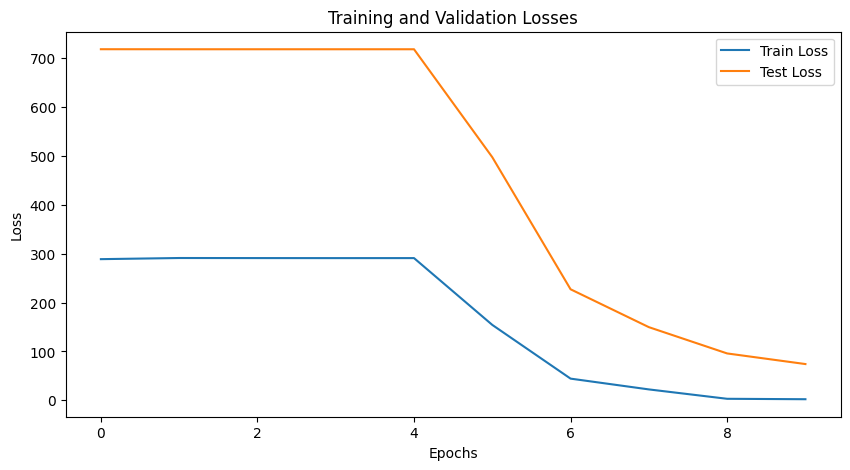

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
#plt.yscale('log')
plt.show()

In [21]:
data[:,2]

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [38]:
df

,met_et,met_phi,lep_pt_0,lep_pt_1,lep_phi_0,lep_phi_1
0,25.118,1.14010,46.439,44.589,2.34760,-2.41510
1,27.974,0.84442,86.819,55.438,-1.44520,-1.72950
2,123.290,-2.94810,105.810,40.506,0.68539,-0.90527
3,78.558,1.04450,56.666,35.124,2.13110,-2.83820
4,15.863,0.74840,94.708,72.811,1.84940,0.45967
...,...,...,...,...,...,...
599995,19.512,2.31050,100.870,20.946,2.83090,2.52390
599996,71.597,-2.28590,46.587,31.701,1.12190,-0.69539
599997,88.197,2.50020,28.382,10.896,-1.29080,-2.76090
599998,21.346,2.00330,47.876,10.330,-0.66946,0.24240
